# Лабораторная работа: кластеризация

## Разделение изображения на семантические компоненты

Загрузите изображение

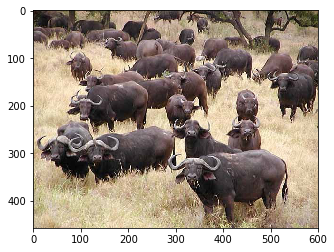

In [1]:
from scipy.misc import imread, imshow
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.cluster import KMeans

img1 = imread('data_hw/bizon.jpg')
fig = plt.figure()
plt.imshow(img1)

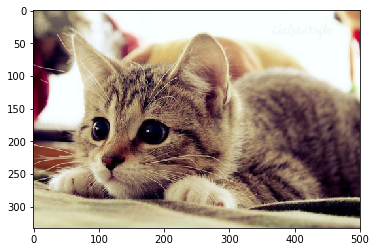

In [2]:
img2 = imread('data_hw/cat.jpg')
fig = plt.figure()
plt.imshow(img2)

**1. (1 балл)** На каждом изображении, используя кластеризацию KMeans, выделите компоненты, охарактеризовав каждый пиксель следующим образом [$\lambda x_i,\lambda y_i,r_i,g_i,b_i$], где $x_i$ и $y_i$ — координаты пикселя, $r_i$,$g_i$,$b_i$ — его цвет, $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.
 
**2. (0.5 балл)** Визуализируйте результаты сегментации.

Определим массив со значениями $\lambda$, число кластеров и вспомогательные функции.

In [3]:
l = np.array([0.1, 0.3, 0.5, 1.0, 1.2, 1.5])
num_clust = 4

In [4]:
def mask_overlay(image, labels, mask, lambda_):
    '''
    Usefull function illustrates image itself and image with mask on top
    '''
    plt.figure(figsize=(20, 20))
    num_cl = len(np.unique(labels))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(image)
    for l in range(num_cl):
        plt.contour(labels == l, colors=[plt.cm.spectral(l / float(num_cl)), ])    
    plt.title('Regions λ=' + str(lambda_))
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(mask)
    plt.title('Mask λ=' + str(lambda_))
    plt.axis("off");

In [5]:
def extract_features(img, l):
    '''
    Function creates an array of features - [l*x_i, l*y_i, r_i, g_i, b_i]
    '''
    img_feat = np.zeros((img.shape[0]*img.shape[1], 5))
    img_ = img.reshape(img.shape[0]*img.shape[1], 3)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img_feat[i*img.shape[1]+j] = np.hstack((l*i,l*j,img_[i*img.shape[1]+j]))
    return img_feat

In [6]:
def clustering(img_feat):
    km = KMeans(n_clusters=num_clust)
    km.fit(img_feat)
    cluster_centers = km.cluster_centers_[:, 2:]
    labels = km.labels_
    mask = cluster_centers[labels]
    return labels, mask

Для начала попробуем сделать кластеризацию д $\lambda$=0.1 и проиллюстрируем результаты.

In [7]:
img1_feat = extract_features(img1, l[0])
img2_feat = extract_features(img2, l[0])

In [8]:
labels1, mask1 = clustering(img1_feat)
mask1 = mask1.reshape(img1.shape)

In [9]:
labels2, mask2 = clustering(img2_feat)
mask2 = mask2.reshape(img2.shape)

Изобразим получившиеся маски.

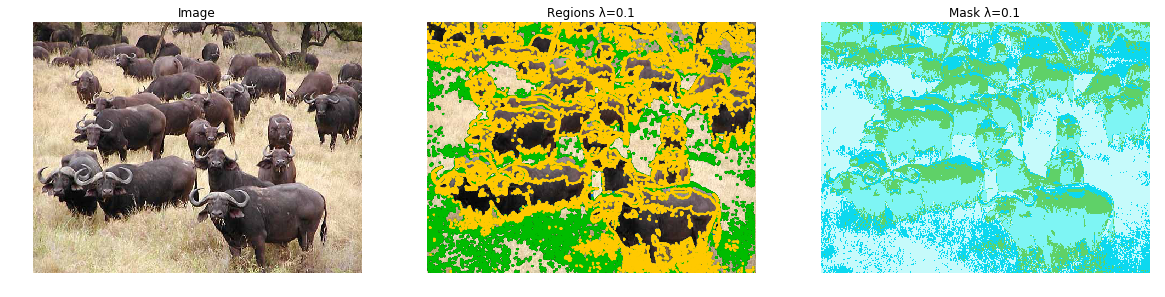

In [10]:
mask_overlay(img1, labels1.reshape(img1.shape[0], img1.shape[1]), mask1, l[0])

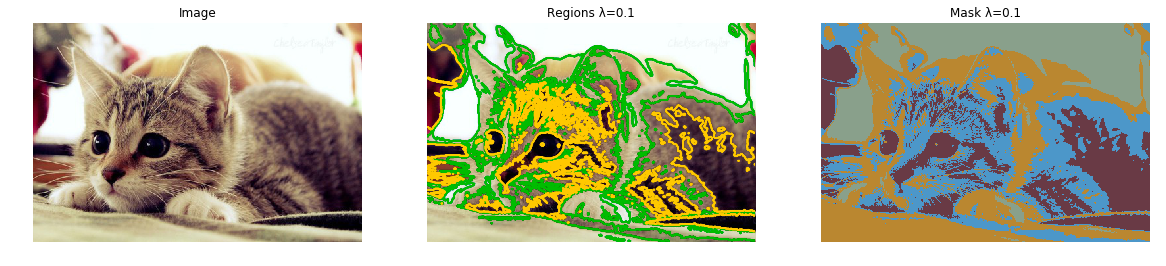

In [11]:
mask_overlay(img2, labels2.reshape(img2.shape[0], img2.shape[1]), mask2, l[0])

Поэкспериментируем с $\lambda$.

In [12]:
res1 = []
res2 = []
for i in l:
    img1_feat = extract_features(img1, i)
    img2_feat = extract_features(img2, i)
    labels1, mask1 = clustering(img1_feat)
    mask1 = mask1.reshape(img1.shape)
    labels2, mask2 = clustering(img2_feat)
    mask2 = mask2.reshape(img2.shape)
    res1.append([labels1, mask1])
    res2.append([labels2, mask2])

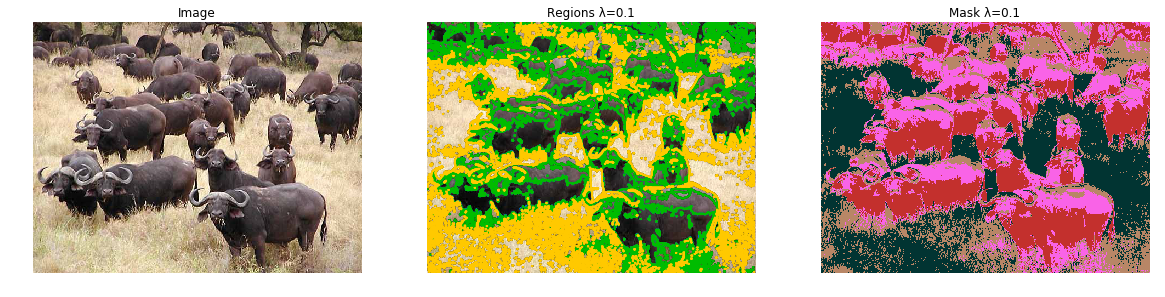

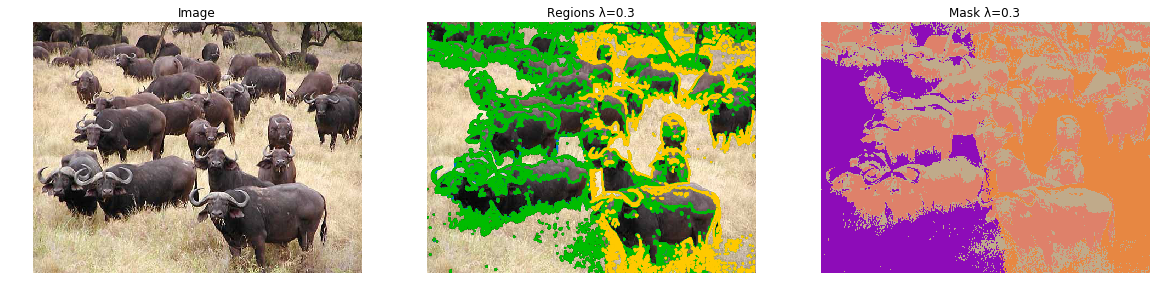

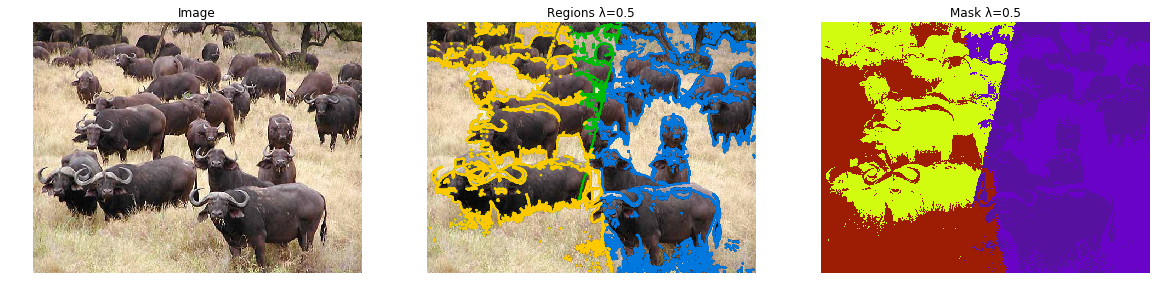

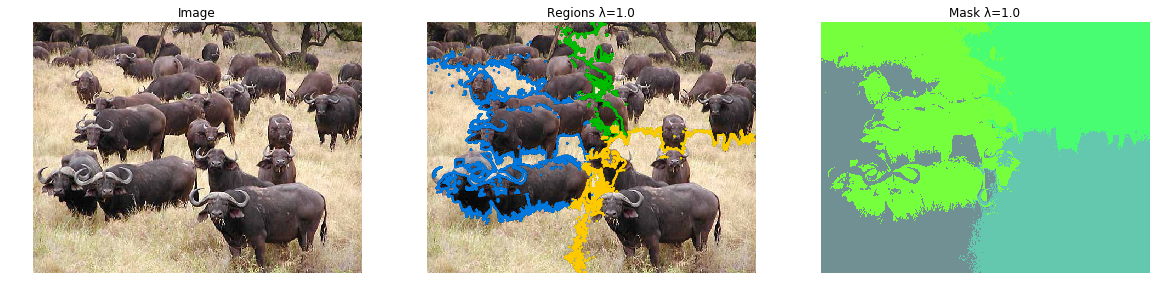

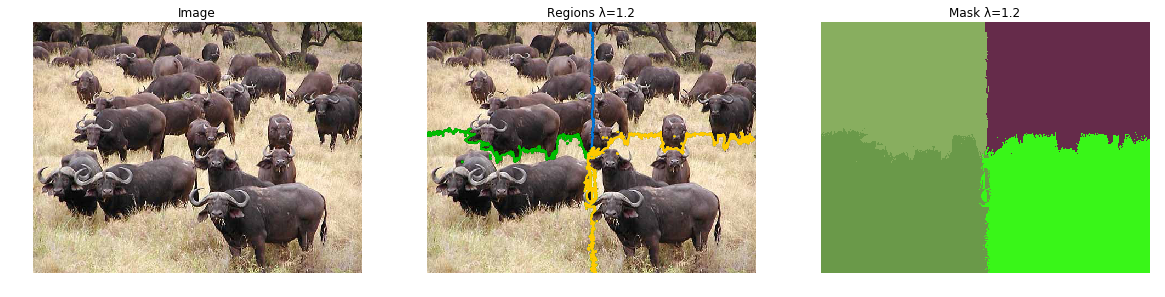

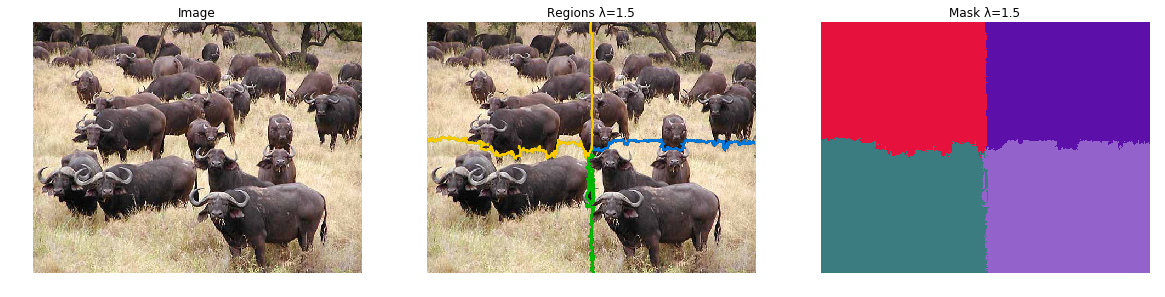

In [14]:
for i in range(len(res1)):
    mask_overlay(img1, res1[i][0].reshape(img1.shape[0], img1.shape[1]), res1[i][1], l[i])

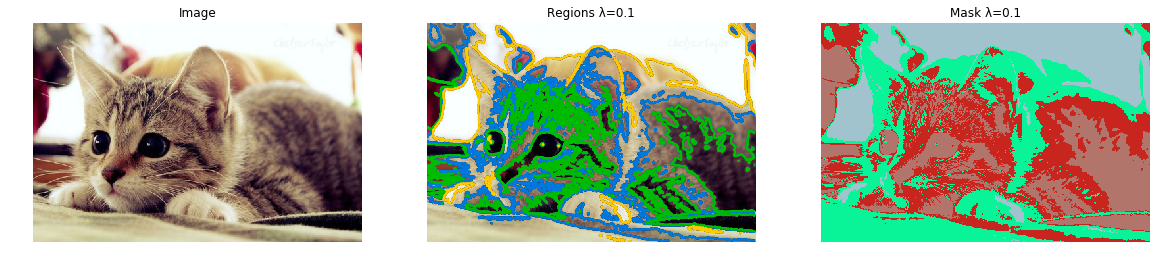

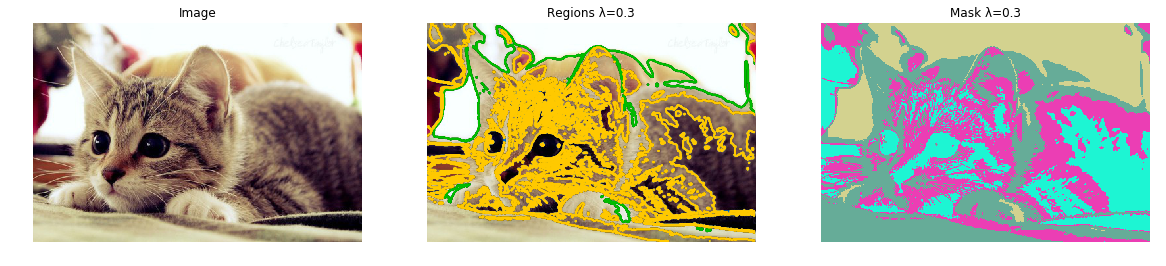

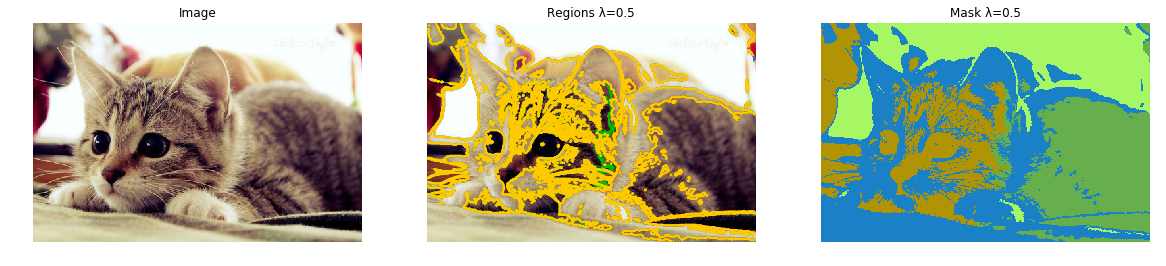

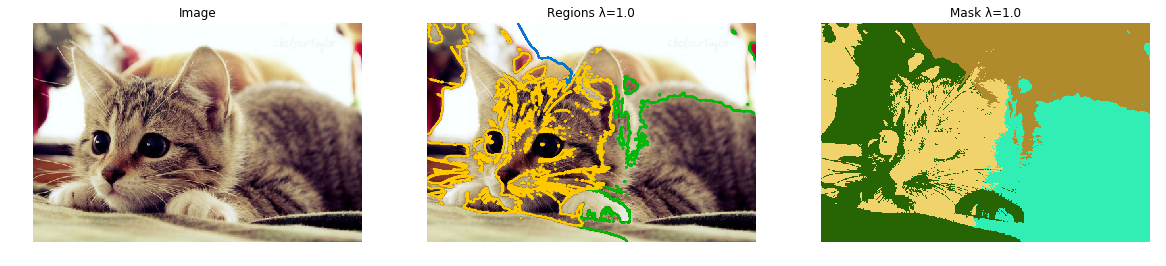

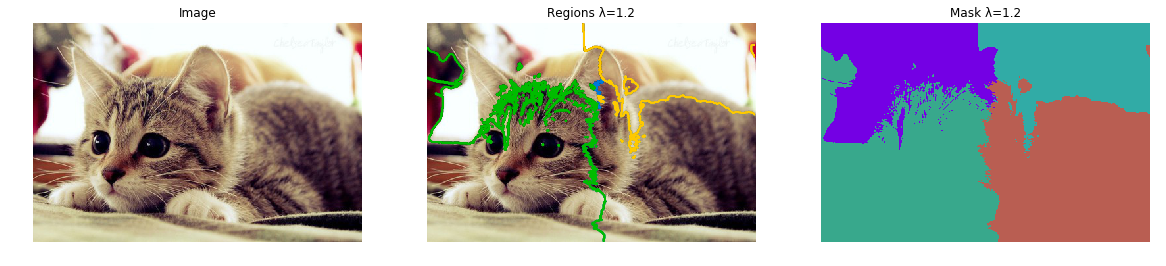

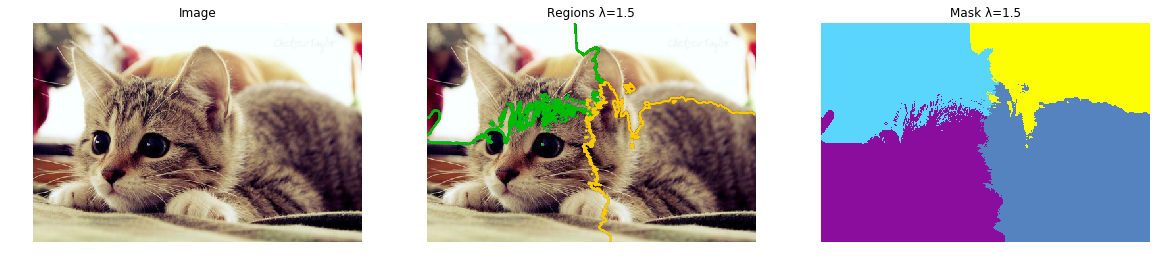

In [15]:
for i in range(len(res2)):
    mask_overlay(img2, res2[i][0].reshape(img2.shape[0], img2.shape[1]), res2[i][1], l[i])

**3. (1 балл)** 
Выделите сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html). Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету.
 
**4. (0.5 балл)** Визуализируйте результаты сегментации (аналогично рисунку выше).

In [5]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

Попробуем спектральную кластеризацию. Есть два подхода к назначению меток:
* ‘kmeans’ 
* ‘discrete’ - итеративный поиск ближайшей границы в векторном пространстве эмбедингов.

In [6]:
def apply_spectral(img, graph):
    plt.figure(figsize=(15, 15))
    i = 1
    for assign_labels in ('kmeans', 'discretize'):
        labels = spectral_clustering(graph, n_clusters=num_clust,
                                     assign_labels=assign_labels,
                                     random_state=42)
        labels = labels.reshape(img.shape)

        plt.subplot(2, 2, i)
        i += 1
        plt.imshow(img,   cmap=plt.cm.gray)
        for l in range(num_clust):
            plt.contour(labels == l,
                        colors=[plt.cm.spectral(l / float(num_clust)), ])
        plt.xticks(())
        plt.yticks(())
    
    plt.show()
    
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [7]:
step = 4
gray1 = rgb2gray(img1)[::step, ::step]
gray2 = rgb2gray(img2)[::step, ::step]
# Convert the image into a graph with the value of the gradient on the edges.
graph1 = image.img_to_graph(gray1)
graph2 = image.img_to_graph(gray2)

beta = 5
eps = 1e-6
graph1.data = np.exp(-beta * graph1.data / gray1.std()) + eps
graph2.data = np.exp(-beta * graph2.data / gray2.std()) + eps

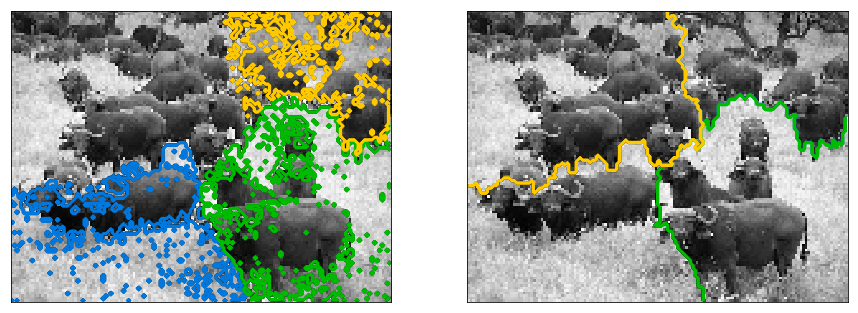

In [8]:
apply_spectral(gray1, graph1)

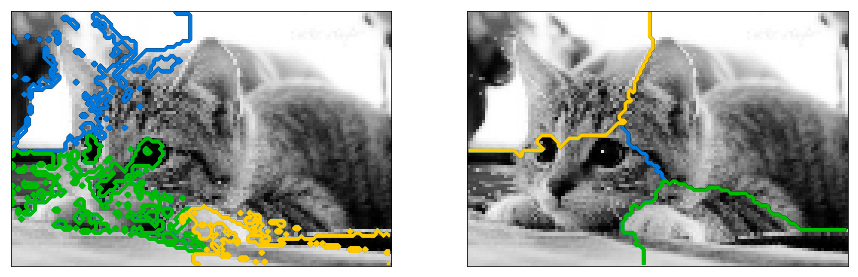

In [9]:
apply_spectral(gray2, graph2)

**5. (1 балл)** Поэкспериментируйте с параметрами алгоритмов и параметром $\lambda$ в признаках. Сравните два метода сегментации.

**6. (0.5 балл)**
Насколько хорошо выделяются объекты на изображениях?

### Алгоритм спектральной кластеризации
[статья](http://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf)

* определить матрицу сходства $A$, используя Гауссово ядрор $K$ ($A_{i,j}\sim exp(-\alpha \Vert x_{i}-x_{j}\Vert^{2}) $) или просто матрице смежности (например $A_{i,j}=\delta_{i,j}$),
* построить лапласиан по $A$, например $L=D-A$ - простой, $L_{N}=D^{-1/2}LD^{-1/2}$ - нормализованный, где $D_{i,i}=\sum^{n}_{j}a_{i,j}$ - диагональная матрица,
* свойство лапласиана - $x^{T}Lx=\frac{1}{2}\sum_{i,j=1}^{n}w_{i,j}\Vert x_{i}-x_{j}\Vert^{2}$,
* найти собственные значения $L v=\lambda v$   (или решить обобщенную задачу $L v=\lambda D v$ )
* выбрать $k$ собтвенных векторов $\{ v_{i}, i=1, k \}$, соответствующих $k$ наименьшим (или наибольшим) собственным значениям  $\{ \lambda_{i}, i=1, k \}$ , и задать $k$-мерное подпространство $P^{T}LP$,
* найти кластеры в этом подпространстве.

In [8]:
D1 = np.zeros(graph1.shape)
D2 = np.zeros(graph2.shape)
for i in range(graph1.shape[0]):
    D1[i, i] = np.sum(graph1.tocsr()[i])

for i in range(graph2.shape[0]):
    D2[i, i] = np.sum(graph2.tocsr()[i])

In [9]:
from scipy.sparse import coo_matrix

In [10]:
L1 = coo_matrix(D1 - graph1)
L2 = coo_matrix(D2 - graph2)

In [11]:
from scipy.linalg import eigh

In [18]:
L1.da

AttributeError: zero not found

In [13]:
eig1 = eigh(L1.data)

ValueError: expected square matrix

In [13]:
eig1.shape

(array([ 0.02161048,  0.04216989,  0.042852  ,  0.0445675 ,  0.08111868,
         0.08284425,  0.08386953,  0.12169152,  0.13095301,  0.13268875,
         0.17556631,  0.18126268,  0.1813679 ,  0.18271938,  0.19555665,
         0.19976757,  0.21525957,  0.21890264,  0.23580288,  0.23742169,
         0.24013378,  0.25099204,  0.26304273,  0.30534383,  0.31172987,
         0.3609896 ,  0.38221903,  0.38408934,  0.38743997,  0.39490195,
         0.41962863,  0.44266177,  0.44505532,  0.44958843,  0.45752558,
         0.4610657 ,  0.4893117 ,  0.49767725,  0.54780843,  0.5634064 ,
         0.56477289,  0.60680695,  0.63251397,  0.65460201,  0.66688551,
         0.6718068 ,  0.68167441,  0.682592  ,  0.68527911,  0.70388202,
         0.74595452,  0.83298721,  0.8515005 ,  0.8638062 ,  0.8766453 ,
         0.92649041,  0.95045764,  0.95820948,  0.96286915,  0.97004274,
         0.97103691,  1.00889294,  1.01668261,  1.04327362,  1.05201667,
         1.07512466,  1.10365625,  1.14848641,  1.1

**7. (2 доп. балла)** Визуализируйте первые несколько собственных векторов, соответствующие самым маленьким собственным числам.
Для этого вам надо более детально ознакомиться с тем, как  работает алгоритм (см. [статью](http://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf)).

Вам может помочь [исходный код sklearn](https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/manifold/spectral_embedding_.py#L133) и функции из scipy: eigh, eigsh, lobpcg.


## Сжатие информации с помощью SVD

Выберите любую из картинок.
Приведите ее к серому цвету.

Чёрно-белая картинка - матрица, элементы которой - насыщенность серого цвета каждого из пикселей.

**Замечание.** Главные компоненты - это не скрытые признаки, а матрицы вида $u^{(i)}\sigma_i(v^{(i)})^T$, где $u^{(i)}, v^{(i)}$ --- столбцы матриц $U$ и $V$ соответственно. В частности, сумма первых нескольких главных компонент --- это наилучшее приближение исходной матрицы матрицей данного ранга.


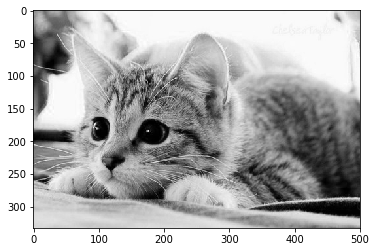

In [3]:
img = imread(r'data_hw/cat.jpg')[:,:,0]# матрица интенсивностей
plt.gray()
imgplot = plt.imshow(img)
plt.show()

**8. (1 балл)** Постройте сингулярное разложение этой матрицы (не центрируя данные). 

**9. (1 балл)** Визуализуйте первую главную компоненту. Что получилось? Почему?

**10. (0.5 балл)** Визуализуйте компоненты с первой по двадцатую, с первой по пятидесятую, с двадцатой по сотую, с двадцатой по последнюю. Что получилось и почему?
Сколько первых компонент нужно взять для достаточно хорошего восстановления исходного изображения?

**11. (0.5 балл)** Как изменится результат, если сначала вы центрируете данные?



In [21]:
from sklearn.decomposition import randomized_svd

In [43]:
U, S, V = randomized_svd(img, n_components=125)

Визуализируем первую главную компоненту:

In [44]:
def vis_reconst(num1, num2):
    reconst = np.matrix(U[:, num1:num2]) * np.diag(S[num1:num2]) * np.matrix(V[num1:num2, :])
    plt.imshow(reconst, plt.cm.gray)
    plt.axis('off')
    if num2 == -1:
        plt.title('Main components ' + str(num1) + ' - last')
    else:
        plt.title('Main components ' + str(num1) + ' - ' + str(num2))

Визуализируем больше главных компонент и пронаблюдаем какие лучше всего восстанавливают изображение.

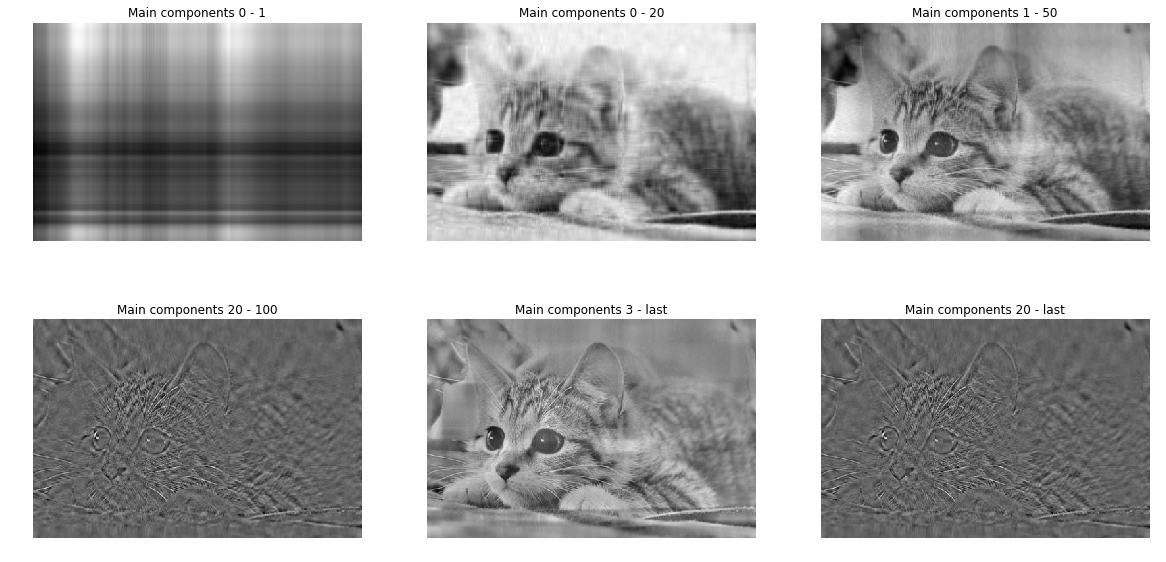

In [46]:
steps = [[0, 1], [0, 20], [1, 50], [20, 100], [3, -1], [20, -1]]
fig = plt.figure(figsize=(20, 20))
count = 1
for i in steps:
    fig.add_subplot(count // 4 + 1, len(steps) / 2, count)
    vis_reconst(num1=i[0], num2=i[1])
    count += 1

In [47]:
mean = np.mean(img.astype("float"))
img_center = img.astype("float") - mean

In [48]:
U, S, V = randomized_svd(img_center, n_components=125)

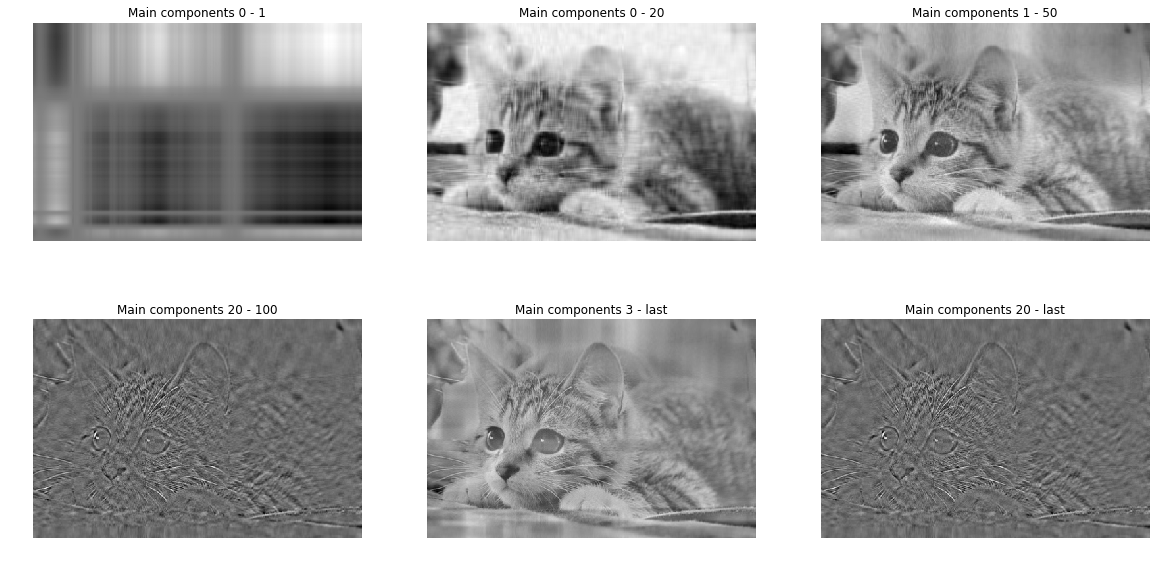

In [49]:
steps = [[0, 1], [0, 20], [1, 50], [20, 100], [3, -1], [20, -1]]
fig = plt.figure(figsize=(20, 20))
count = 1
for i in steps:
    fig.add_subplot(count // 4 + 1, len(steps) / 2, count)
    vis_reconst(num1=i[0], num2=i[1])
    count += 1